## Initial set-up

In [1]:
! pip install wandb

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, WeightedRandomSampler
from torchvision import datasets, transforms as T
import wandb
import json
import numpy as np
import random
import os
from tqdm import tqdm
#For saving the result of the training in a dirve folder 
#from google.colab import drive
#drive.mount('/content/drive')

Initialization of the device and fixing the reproducibility

In [3]:
SEED = 42

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

def fix_random(seed: int) -> None:
    """
        Fix all the possible sources of randomness.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(SEED)

Device: cuda


In [4]:
##Configurations

cfg_data = {
    'std_size' : 224,
    'rand_crop_size' : 150,
    'n_classes' : 43,
}

cfg_hyp = {
    'lr' : 1e-3,
    'wd' : 1e-5,
    'epochs' : 50,
    'batch_size' : 32,
    'scheduler' : True,
    'device' : device,
    'stopping_patience' : 10,
    'stopping_value' : 0.6
}


## Download and exploration of the dataset 

In [10]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293 (from 1)
Receiving objects: 100% (6559/6559), 116.26 MiB | 15.15 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [5]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from typing import List, Tuple

In [6]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1
    
    #My adding for balance the dataset
    def get_class_weights(self) -> torch.Tensor:
        class_counts = np.bincount(self.labels)
        class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
        return class_weights

    def get_sampler(self) -> WeightedRandomSampler:
        class_weights = self.get_class_weights()
        sample_weights = [class_weights[label] for label in self.labels]
        return WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [7]:
## Rimettere a 260x260 o a 224x224 (per resnet)

n_classes = cfg_data['n_classes']

tsfms_std = T.Compose([
    T.ToTensor(),
    T.Resize(size=(cfg_data['std_size'], cfg_data['std_size'])),
    # T.Lambda(lambda x: x.flatten()),
])

#DATA AUGMENTATION
#tsfms_increasing = T.Compose([
#    T.RandomRotation(15),
#    T.RandomResizedCrop(32, scale=(0.9, 1.1)),
#    T.RandomHorizontalFlip(),
#    T.RandomResizedCrop(size=(cfg_data['rand_crop_size'], cfg_data['rand_crop_size']), scale=(0.7, 0.9)),
#    T.ToTensor(),
#    T.Resize(size=(cfg_data['std_size'], cfg_data['std_size'])),
#    # T.Lambda(lambda x: x.flatten()),
#])


#NEWDATAAUGMENTATION
class RandomApply(T.RandomApply):
    def __init__(self, transforms, p=0.5):
        super().__init__(transforms, p=p)

def change_background_color(image):
    background = Image.new('RGB', image.size, (random.randint(200, 255), random.randint(200, 255), random.randint(200, 255)))
    return Image.composite(image, background, image.convert('L').point(lambda x: 255 if x > 5 else 0))


tsfms_increasing = T.Compose([
        T.RandomRotation(10),
        T.RandomResizedCrop(32, scale=(0.9, 1.0)),
        T.RandomHorizontalFlip(p=0.3),
        RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.7),
        RandomApply([T.GaussianBlur(kernel_size=3)], p=0.2),
        T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        RandomApply([T.Lambda(change_background_color)], p=0.3),
        T.RandomResizedCrop(size=(cfg_data['rand_crop_size'], cfg_data['rand_crop_size']), scale=(0.8, 1.0)),
        T.ToTensor(),
        T.Resize(size=(cfg_data['std_size'], cfg_data['std_size'])),
        RandomApply([
            T.Lambda(lambda x: x + 0.02 * torch.randn_like(x))
        ], p=0.2),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


train_dset = GroceryStoreDataset(
    split="train",
    transform=tsfms_std,
)
increased_train_dst = GroceryStoreDataset(
    split="train",
    transform=tsfms_increasing,
)

val_dset = GroceryStoreDataset(
    split="val",
    transform=tsfms_std,
)
test_dset = GroceryStoreDataset(
    split="test",
    transform=tsfms_std,
)
increased_dataset = torch.utils.data.ConcatDataset([increased_train_dst,train_dset]) #-> augmented data

print(f'Train dataset size: {len(train_dset)}')
print(f'Increased train dataset size: {len(increased_dataset)}')
print(f'Validation dataset size: {len(val_dset)}')
print(f'Test dataset size: {len(test_dset)}')

Train dataset size: 2640
Increased train dataset size: 5280
Validation dataset size: 296
Test dataset size: 2485


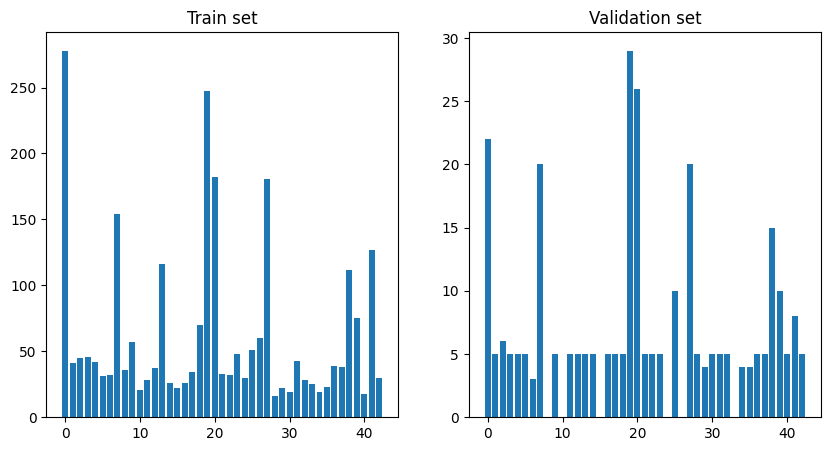

In [8]:
###Balancing data
import matplotlib.pyplot as plt

#-Showing distribution of test and validation set
unique_train_class, counts_train_class = np.unique(train_dset.labels, return_counts=True)
unique_val_class, counts_val_class = np.unique(val_dset.labels, return_counts=True)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(unique_train_class, counts_train_class)
plt.title('Train set')
plt.subplot(1,2,2)
plt.bar(unique_val_class, counts_val_class)
plt.title('Validation set')
plt.show()

In [9]:
train_dl = DataLoader(
    train_dset,
    batch_size=cfg_hyp['batch_size'],
    shuffle=True
)

increased_train_dl = DataLoader(
    increased_dataset,
    batch_size=cfg_hyp['batch_size'],
    shuffle=True
)

balanced_train_dl = DataLoader(
    train_dset,
    sampler=train_dset.get_sampler(),
    batch_size=cfg_hyp['batch_size'],
)


val_dl = DataLoader(
    val_dset,
    batch_size=cfg_hyp['batch_size']
)
test_dl = DataLoader(
    test_dset,
    batch_size=cfg_hyp['batch_size']
)


## Utilty function

In [17]:
#For saving the result 
def create_model_directory(model_name, run):
    # base_path = f"/content/drive/MyDrive/model_results_{run}"
    base_path = f"./model_results_{run}"
    model_path = os.path.join(base_path, model_name)
    os.makedirs(model_path, exist_ok=True)
    return model_path

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
import torch.optim as optim
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name, model_path, stopping_patience = 10, stopping_value = 0.6, scheduler_check=False, WANDB=False):

    model.to(device)
    best_val_acc = 0.0
    if scheduler_check:
      scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr = 1e-6)

    if device == 'cuda':
      torch.cuda.empty_cache()

    num_params = count_parameters(model)

    run_stats = {
        "model_name": model_name,
        "num_parameters": num_params,
        "epochs": []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        if scheduler_check:
          scheduler.step(val_loss)
          last_lr = scheduler.get_last_lr()[0]

        epoch_time = time.time() - start_time

        epoch_stats = {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "epoch_time": epoch_time
        }

        run_stats["epochs"].append(epoch_stats)

        if WANDB:
          wandb.log(epoch_stats)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Time: {epoch_time:.2f}s, "
              f"Last leraning rate: {last_lr}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stopping_counter = 0
            torch.save(model.state_dict(), os.path.join(model_path, f"{model_name}_best.pth"))
            if WANDB:
              wandb.save(f"{model_name}_best.pth")

        else:
          early_stopping_counter += 1
          print(f"EarlyStoppingCounter: {early_stopping_counter} out of {stopping_patience}")

        if early_stopping_counter >= stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        if val_acc > stopping_value:
            print(f"Stopping value reached at epoch {epoch+1}")
            break

    with open(os.path.join(model_path, f"{model_name}_run_stats.json"), "w") as f:
        json.dump(run_stats, f, indent=2)

    return best_val_acc

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy

def train_and_evaluate(model_class, name, train_loader, val_loader, test_loader, num_classes, model_path, num_epochs=50, lr=0.001, wd=1e-5, device='cuda', stopping_patience = 10, stopping_value = 0.6, scheduler_check=False, WANDB=False):

    model = model_class(num_classes=num_classes).to(device)
    if WANDB:
       wandb.init(project="grocery-store-classification", name=name)
       wandb.watch(model)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    best_val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, name, model_path, stopping_patience, stopping_value, scheduler_check, WANDB)

    # Load the best model for final evaluation
    model.load_state_dict(torch.load(os.path.join(model_path, f"{name}_best.pth")))
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

    print(f"Final results for {name}:")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    if WANDB:
      wandb.log({
          "best_val_acc": best_val_acc,
          "test_acc": test_acc
      })

    json_path = os.path.join(model_path, f"{name}_run_stats.json")
    with open(json_path, "r") as f:
        run_stats = json.load(f)

    run_stats["best_val_acc"] = best_val_acc
    run_stats["test_acc"] = test_acc

    with open(json_path, "w") as f:
        json.dump(run_stats, f, indent=2)

    if WANDB:
      wandb.finish()


    return best_val_acc, test_acc

## Networks

In [25]:
import torch.nn.functional as F

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [27]:
# import torch.nn.functional as Fx

##Tutte le reti tranne l'ultima non le ho testate, sono per l ablation study

class MoreFullyConnectedNet(nn.Module):   #-> da vedere meglio come farla
    def __init__(self, num_classes=43):
        super(MoreFullyConnectedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        #self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128,256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #out = self.dropout1(out)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        #out = self.dropout2(out)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out


class NetWithoutBatchNorm(nn.Module):
    def __init__(self, num_classes=43):
        super(NetWithoutBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        #self.dropout2 = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        #out = self.dropout1(out)
        x = self.avg_pool(x)
        out = x.view(x.size(0), -1)
        #out = self.dropout2(out)
        out = self.fc(out)
        return out


class NetWithoutResidualBlock(nn.Module):
    def __init__(self, num_classes=43):
        super(NetWithoutResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        #self.dropout2 = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        #out = self.dropout1(out)
        x = self.avg_pool(x)
        out = x.view(x.size(0), -1)
        #out = self.dropout2(out)
        out = self.fc(out)
        return out


class NetWihtoutDropout(nn.Module):
    def __init__(self, num_classes=43):
        super(NetWihtoutDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = ResidualBlock(64, 64)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.layer4 = ResidualBlock(256, 512, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


#BesttNet -> ResidualBlock + dropout best combination: best performance 0.58 with lr = 1e-3, wd = 1e-5 without scheduler -> da cambiare gli hyp ma ci siamo
class GroceryConvNet(nn.Module):
    def __init__(self, num_classes=43):
        super(GroceryConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = ResidualBlock(64, 64)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.layer4 = ResidualBlock(256, 512, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        #self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        #out = self.dropout1(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout2(out)
        out = self.fc(out)
        return out

In [23]:
####Prova da non guardare
model = GroceryConvNet
name = 'ultimate_cnn'
model_path = create_model_directory(model_name= name, run=1)
best_val_acc, test_acc = train_and_evaluate(
    model_class = model,
    name = name,
    train_loader = increased_train_dl,
    val_loader = val_dl,
    test_loader = test_dl,
    num_classes = n_classes,
    model_path = model_path,
    num_epochs=cfg_hyp['epochs'],
    lr=cfg_hyp['lr'],
    wd=cfg_hyp['wd'],
    device='cuda',
    stopping_patience = cfg_hyp['stopping_patience'],
    stopping_value = cfg_hyp['stopping_value'],
    scheduler_check=True,
    WANDB=False
)


Epoch 1/50, Train Loss: 3.4162, Train Acc: 0.1576, Val Loss: 3.1848, Val Acc: 0.2128, Time: 167.57s, Last leraning rate: 0.01
Epoch 2/50, Train Loss: 3.0229, Train Acc: 0.2210, Val Loss: 3.0022, Val Acc: 0.2061, Time: 171.06s, Last leraning rate: 0.01
EarlyStoppingCounter: 1 out of 10
Epoch 3/50, Train Loss: 2.8957, Train Acc: 0.2564, Val Loss: 2.8538, Val Acc: 0.2973, Time: 171.44s, Last leraning rate: 0.01
Epoch 4/50, Train Loss: 2.8246, Train Acc: 0.2828, Val Loss: 3.3135, Val Acc: 0.2534, Time: 171.27s, Last leraning rate: 0.01
EarlyStoppingCounter: 1 out of 10
Epoch 5/50, Train Loss: 2.7482, Train Acc: 0.3023, Val Loss: 2.8638, Val Acc: 0.2939, Time: 171.67s, Last leraning rate: 0.01
EarlyStoppingCounter: 2 out of 10


KeyboardInterrupt: 

In [28]:
##Ciclo sui modelli da testare su una cpu capace -> uso data augmentation, learning scheduler e batch_size = 32
model = [MoreFullyConnectedNet, NetWithoutBatchNorm, NetWithoutResidualBlock, NetWihtoutDropout, GroceryConvNet]
model_name = ['NetMoreFullyConnected.cnn', 'NetWithoutBatchNorm.cnn', 'NetWithoutResidualBlock.cnn', 'NetWihtoutDropout.cnn', 'GroceryConvNet.cnn']
experiments = zip(model, model_name)

for run in range(1,4): #-> se volessi fare più run ma per questioni tempo-gpu la escluderei
  for exp in experiments:
    model, model_name = exp
    model_path = create_model_directory(model_name= model_name, run=run)
    best_val_acc, test_acc = train_and_evaluate(
    model_class = model,
    # name = name,
    name = model_name,
    train_loader = increased_train_dl,
    val_loader = val_dl,
    test_loader = test_dl,
    num_classes = n_classes,
    model_path = model_path,
    num_epochs=cfg_hyp['epochs'],
    lr=cfg_hyp['lr'],
    wd=cfg_hyp['wd'],
    device=cfg_hyp['device'],
    stopping_patience = cfg_hyp['stopping_patience'],
    stopping_value = cfg_hyp['stopping_value'],
    scheduler_check=cfg_hyp['scheduler'],
    WANDB=True
)


Epoch 1/50, Train Loss: 3.2879, Train Acc: 0.1646, Val Loss: 3.1167, Val Acc: 0.2027, Time: 57.79s, Last leraning rate: 0.001
Epoch 2/50, Train Loss: 2.9973, Train Acc: 0.2191, Val Loss: 2.9649, Val Acc: 0.2230, Time: 58.07s, Last leraning rate: 0.001
Epoch 3/50, Train Loss: 2.8550, Train Acc: 0.2462, Val Loss: 2.9155, Val Acc: 0.2162, Time: 58.12s, Last leraning rate: 0.001
EarlyStoppingCounter: 1 out of 10
Epoch 4/50, Train Loss: 2.7575, Train Acc: 0.2670, Val Loss: 2.9833, Val Acc: 0.2027, Time: 57.72s, Last leraning rate: 0.001
EarlyStoppingCounter: 2 out of 10
Epoch 5/50, Train Loss: 2.6979, Train Acc: 0.2890, Val Loss: 2.8699, Val Acc: 0.2365, Time: 57.43s, Last leraning rate: 0.001
Epoch 6/50, Train Loss: 2.5834, Train Acc: 0.3218, Val Loss: 2.8119, Val Acc: 0.2568, Time: 60.44s, Last leraning rate: 0.001
Epoch 7/50, Train Loss: 2.4959, Train Acc: 0.3430, Val Loss: 2.7630, Val Acc: 0.2770, Time: 64.05s, Last leraning rate: 0.001
Epoch 8/50, Train Loss: 2.4195, Train Acc: 0.3748,

best_val_acc,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch_time,▂▂▂▂▁▄█▅▁▁▁▂▁▁▁▁▂▂▃▂▂▂▂▂▁▂▂▁▁▁
test_acc,▁
train_acc,▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█▇████
train_loss,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▂▂▁▂▃▄▆▅▅▅▄▅▅▆█▇█▆█▇▇▇▇▇████▇
val_loss,█▆▆▇▆▅▄▂▄▃▃▃▃▁▃▂▂▂▄▁▂▃▂▃▃▂▂▂▃▃
best_val_acc,0.37838
epoch,30
epoch_time,57.42233


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.06 GiB. GPU 

In [ ]:
##Iperparametri mi sa che ha senso poi farlo manualmente
# - Impostando scheduler come False (partendo lr di 1e-3)
# - Passando train_dl
# - Cambiando il batch size (16, 64) ???
# - Passando il dataset bilanciato


COSA RESTA DA FARE:
- Testare sulle varie reti plottando i vari grafici (farlo in locale sarebbe fighissimo, capiamo)
- Sulla rete migliore variare gli iperparametri (come no o si scheduler o per leraning rate o comunque qualcosa legato al learning rate, batch_size, si e no data augmentation)

-> così in totale avrei 5 grafici per le reti e 4 per gli iperparametri

- Migliorare questione scheduler perchè effettivamente anche con true non so se sta funzionando

- Usare nn.Sequential (?) così necessario (?)

Alla fine meglio fare ablation study per capire sia riguardo gli iperparamentri che la rete quale è il milgioramento più efficace